<a href="https://colab.research.google.com/github/monimoyd/S9/blob/master/S9_main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment S7
Model Trained on CIFAR Data 
Accuracy > 85%

# Import all the required Libraries 

In [ ]:
%matplotlib inline
import autoreload
%load_ext autoreload
%autoreload

We need to import Albumentations Library to this notebook for performing image augmentation activities


In [ ]:
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-1y3wqh5y
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-1y3wqh5y
  Created wheel for albumentations: filename=albumentations-1.0.0-cp37-none-any.whl size=98151 sha256=a1b0819bf539eb825f4d41a96b3d2853791beb156f745137448def97d2c944c1
  Stored in directory: /tmp/pip-ephem-wheel-cache-fx44t6fl/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


## Mount the google drive

In [ ]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


change the directory to include the python packages

In [ ]:
import os
os.chdir('/content/drive/MyDrive')

## Copy all the API python files from the google drive to local folder

Follwing python files are imported from google drive. Purpsoe of these files are as below:

model.py - Defines the model class Net
train_test.py- API for training and testing
accuracy_utils - API foro getting test accuracy and per class accuracy
data_loader.py - API for loading train and test data
data_transform.py - API for transforming and normalizing data
plot_metrics.py - API for plotting metrics

In [ ]:
!cp -rf '/content/drive/My Drive/eva_apis/data_loaders' .
!cp -rf '/content/drive/My Drive/eva_apis/data_transformations' .
!cp -rf '/content/drive/My Drive/eva_apis/models' .
!cp -rf '/content/drive/My Drive/eva_apis/utils' .

## Import all the libraries

In [ ]:
from PIL import Image
import cv2
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from data_transformations.data_transform_cifar10 import get_train_transform, get_test_transform
from data_loaders.cifar10_data_loader import get_train_loader, get_test_loader, get_classes
from models.model import Net
from utils.train_test_utils import train,test
from utils.accuracy_utils import get_test_accuracy,get_accuracy_per_class
from utils.plot_metrics_utils import plot_loss_accuracy
from utils.misclassified_image_utils import  display_misclassfied_ciphar10_images





Training a Classifier
=====================



Training an image classifier
----------------------------

I have done the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data





 ## 1. Loading and normalizing CIFAR10

 I have used APIs get_train_loader, get_test_loader to load train data and test data respectively. Both the APIs internally uses torchvision. I have used get_transform API to transform tensors in the range [-1,1]



In [ ]:
transform_train = get_train_transform()
transform_test = get_test_transform()

trainloader = get_train_loader(128, transform_train)
testloader = get_test_loader(128, transform_test)
classes = get_classes()


Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


## Visualizing some of the images in train dataset



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 ship horse   car  ship


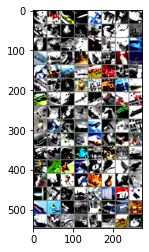

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2. Define a Convolution Neural Network




In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model =  Net().to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]           9,216
              ReLU-5           [-1, 32, 32, 32]               0
       BatchNorm2d-6           [-1, 32, 32, 32]              64
            Conv2d-7           [-1, 64, 32, 32]          18,432
              ReLU-8           [-1, 64, 32, 32]               0
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 32, 17, 17]           2,048
             ReLU-11           [-1, 32, 17, 17]               0
      BatchNorm2d-12           [-1, 32, 17, 17]              64
           Conv2d-13           [-1, 32, 15, 15]           9,216
             ReLU-14           [-1, 32,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## 3. Define a Loss function and optimizer and train the model

I have used Classification Cross-Entropy loss and SGD with learning rate 0.01 with momentum 0.9.

## 4. Train the model

 I have used 100 epochs to train the model

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm


def train(model, device, train_loader, optimizer, epoch, train_losses,train_acc, l1_param=0.0 ):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    loss_list = []
    for batch_idx, (data, target) in enumerate(pbar):
        # get samples
        data, target = data.to(device), target.to(device)

        # Init
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
        # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

        # Predict
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        if l1_param > 0.0 :
            regularization_loss = 0.0

            for param in model.parameters():
                if param.dim() > 1 :
                    regularization_loss += param.norm(1)
    
            regularization_loss *= l1_param
            loss += regularization_loss

        loss_list.append(loss.item())

        # Backpropagation
        loss.backward()
        optimizer.step()

        # Update pbar-tqdm
    
        pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    avg_loss = sum(loss_list)/len(loss_list)
    train_losses.append(avg_loss)
	
def test(model, device, test_loader, test_losses, test_acc):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
	

# Define lists to capture training parameters 

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []



In [ ]:
from torch.optim.lr_scheduler import StepLR
import torch.optim as optim

model =  Net().to(device)
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,  weight_decay=0.0001)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=25, gamma=0.1)

from torch.optim.lr_scheduler import ReduceLROnPlateau

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=5, verbose=True)
MODEL_PATH = '/content/drive/My Drive/ciphar10_latest_s7.pt'

best_test_loss = float('inf')
EPOCHS = 100
for epoch in range(EPOCHS):
    print("EPOCH:", (epoch + 1))
    train(model, device, trainloader, optimizer, epoch, train_losses,train_acc )
    test(model, device, testloader, test_losses, test_acc)
    test_loss = test_losses[-1]
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(model.state_dict(), MODEL_PATH )
    scheduler.step(test_loss)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=1.4753371477127075 Batch_id=390 Accuracy=27.30: 100%|██████████| 391/391 [00:16<00:00, 23.98it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.5092, Accuracy: 4356/10000 (43.56%)

EPOCH: 2


Loss=1.359220027923584 Batch_id=390 Accuracy=41.34: 100%|██████████| 391/391 [00:16<00:00, 23.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.3593, Accuracy: 4991/10000 (49.91%)

EPOCH: 3


Loss=1.5478036403656006 Batch_id=390 Accuracy=46.46: 100%|██████████| 391/391 [00:16<00:00, 23.44it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.2062, Accuracy: 5804/10000 (58.04%)

EPOCH: 4


Loss=1.3300455808639526 Batch_id=390 Accuracy=49.88: 100%|██████████| 391/391 [00:16<00:00, 23.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.1282, Accuracy: 5907/10000 (59.07%)

EPOCH: 5


Loss=1.2036802768707275 Batch_id=390 Accuracy=52.48: 100%|██████████| 391/391 [00:16<00:00, 24.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.0161, Accuracy: 6402/10000 (64.02%)

EPOCH: 6


Loss=1.2031704187393188 Batch_id=390 Accuracy=54.25: 100%|██████████| 391/391 [00:16<00:00, 24.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9450, Accuracy: 6658/10000 (66.58%)

EPOCH: 7


Loss=1.1190826892852783 Batch_id=390 Accuracy=56.09: 100%|██████████| 391/391 [00:16<00:00, 24.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.9029, Accuracy: 6880/10000 (68.80%)

EPOCH: 8


Loss=1.1373236179351807 Batch_id=390 Accuracy=57.94: 100%|██████████| 391/391 [00:16<00:00, 24.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8745, Accuracy: 6959/10000 (69.59%)

EPOCH: 9


Loss=1.0929912328720093 Batch_id=390 Accuracy=59.17: 100%|██████████| 391/391 [00:16<00:00, 24.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8582, Accuracy: 7051/10000 (70.51%)

EPOCH: 10


Loss=1.0440618991851807 Batch_id=390 Accuracy=60.51: 100%|██████████| 391/391 [00:16<00:00, 24.34it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8094, Accuracy: 7164/10000 (71.64%)

EPOCH: 11


Loss=1.339372992515564 Batch_id=390 Accuracy=61.62: 100%|██████████| 391/391 [00:16<00:00, 24.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7965, Accuracy: 7238/10000 (72.38%)

EPOCH: 12


Loss=1.036113977432251 Batch_id=390 Accuracy=61.86: 100%|██████████| 391/391 [00:16<00:00, 24.26it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7850, Accuracy: 7300/10000 (73.00%)

EPOCH: 13


Loss=1.0330637693405151 Batch_id=390 Accuracy=62.72: 100%|██████████| 391/391 [00:16<00:00, 24.16it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8202, Accuracy: 7152/10000 (71.52%)

EPOCH: 14


Loss=1.2119812965393066 Batch_id=390 Accuracy=63.39: 100%|██████████| 391/391 [00:16<00:00, 24.09it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7374, Accuracy: 7425/10000 (74.25%)

EPOCH: 15


Loss=1.2412424087524414 Batch_id=390 Accuracy=64.40: 100%|██████████| 391/391 [00:16<00:00, 24.13it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7324, Accuracy: 7478/10000 (74.78%)

EPOCH: 16


Loss=0.9884735345840454 Batch_id=390 Accuracy=64.54: 100%|██████████| 391/391 [00:16<00:00, 24.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6995, Accuracy: 7595/10000 (75.95%)

EPOCH: 17


Loss=1.1318960189819336 Batch_id=390 Accuracy=65.29: 100%|██████████| 391/391 [00:16<00:00, 23.99it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6688, Accuracy: 7739/10000 (77.39%)

EPOCH: 18


Loss=1.1718692779541016 Batch_id=390 Accuracy=65.45: 100%|██████████| 391/391 [00:16<00:00, 24.00it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7028, Accuracy: 7641/10000 (76.41%)

EPOCH: 19


Loss=1.0232021808624268 Batch_id=390 Accuracy=66.56: 100%|██████████| 391/391 [00:16<00:00, 24.18it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6461, Accuracy: 7774/10000 (77.74%)

EPOCH: 20


Loss=0.9021393656730652 Batch_id=390 Accuracy=66.32: 100%|██████████| 391/391 [00:16<00:00, 24.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6493, Accuracy: 7748/10000 (77.48%)

EPOCH: 21


Loss=0.9363788366317749 Batch_id=390 Accuracy=67.03: 100%|██████████| 391/391 [00:16<00:00, 24.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6382, Accuracy: 7843/10000 (78.43%)

EPOCH: 22


Loss=0.827009379863739 Batch_id=390 Accuracy=67.43: 100%|██████████| 391/391 [00:16<00:00, 24.06it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6276, Accuracy: 7859/10000 (78.59%)

EPOCH: 23


Loss=1.1471221446990967 Batch_id=390 Accuracy=67.77: 100%|██████████| 391/391 [00:16<00:00, 24.07it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6299, Accuracy: 7860/10000 (78.60%)

EPOCH: 24


Loss=1.118955135345459 Batch_id=390 Accuracy=68.02: 100%|██████████| 391/391 [00:16<00:00, 24.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6174, Accuracy: 7916/10000 (79.16%)

EPOCH: 25


Loss=0.7056847214698792 Batch_id=390 Accuracy=68.65: 100%|██████████| 391/391 [00:16<00:00, 24.20it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6127, Accuracy: 7915/10000 (79.15%)

EPOCH: 26


Loss=0.8780961036682129 Batch_id=390 Accuracy=68.92: 100%|██████████| 391/391 [00:16<00:00, 24.15it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5897, Accuracy: 7982/10000 (79.82%)

EPOCH: 27


Loss=0.9959356188774109 Batch_id=390 Accuracy=69.21: 100%|██████████| 391/391 [00:16<00:00, 23.86it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6096, Accuracy: 7952/10000 (79.52%)

EPOCH: 28


Loss=0.9526691436767578 Batch_id=390 Accuracy=69.23: 100%|██████████| 391/391 [00:16<00:00, 24.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5974, Accuracy: 7969/10000 (79.69%)

EPOCH: 29


Loss=0.9074935913085938 Batch_id=390 Accuracy=69.85: 100%|██████████| 391/391 [00:16<00:00, 24.14it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5779, Accuracy: 8024/10000 (80.24%)

EPOCH: 30


Loss=1.2098515033721924 Batch_id=390 Accuracy=69.86: 100%|██████████| 391/391 [00:16<00:00, 24.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5825, Accuracy: 8036/10000 (80.36%)

EPOCH: 31


Loss=0.8743487596511841 Batch_id=390 Accuracy=69.92: 100%|██████████| 391/391 [00:16<00:00, 23.96it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5702, Accuracy: 8043/10000 (80.43%)

EPOCH: 32


Loss=0.8558562994003296 Batch_id=390 Accuracy=70.69: 100%|██████████| 391/391 [00:16<00:00, 23.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6011, Accuracy: 7984/10000 (79.84%)

EPOCH: 33


Loss=0.8616722226142883 Batch_id=390 Accuracy=70.44: 100%|██████████| 391/391 [00:16<00:00, 23.90it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5706, Accuracy: 8048/10000 (80.48%)

EPOCH: 34


Loss=0.6838943362236023 Batch_id=390 Accuracy=70.84: 100%|██████████| 391/391 [00:16<00:00, 24.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5721, Accuracy: 8071/10000 (80.71%)

EPOCH: 35


Loss=0.7712998986244202 Batch_id=390 Accuracy=71.24: 100%|██████████| 391/391 [00:16<00:00, 23.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5593, Accuracy: 8077/10000 (80.77%)

EPOCH: 36


Loss=0.8013245463371277 Batch_id=390 Accuracy=71.26: 100%|██████████| 391/391 [00:16<00:00, 23.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5668, Accuracy: 8055/10000 (80.55%)

EPOCH: 37


Loss=0.7956869006156921 Batch_id=390 Accuracy=71.60: 100%|██████████| 391/391 [00:16<00:00, 24.01it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5493, Accuracy: 8169/10000 (81.69%)

EPOCH: 38


Loss=0.732079267501831 Batch_id=390 Accuracy=71.24: 100%|██████████| 391/391 [00:16<00:00, 23.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5516, Accuracy: 8148/10000 (81.48%)

EPOCH: 39


Loss=0.8031419515609741 Batch_id=390 Accuracy=71.56: 100%|██████████| 391/391 [00:16<00:00, 23.95it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5356, Accuracy: 8167/10000 (81.67%)

EPOCH: 40


Loss=0.7783316373825073 Batch_id=390 Accuracy=71.96: 100%|██████████| 391/391 [00:16<00:00, 23.97it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5633, Accuracy: 8137/10000 (81.37%)

EPOCH: 41


Loss=0.9116802215576172 Batch_id=390 Accuracy=72.21: 100%|██████████| 391/391 [00:16<00:00, 23.83it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5377, Accuracy: 8164/10000 (81.64%)

EPOCH: 42


Loss=0.6000967621803284 Batch_id=390 Accuracy=72.40: 100%|██████████| 391/391 [00:16<00:00, 24.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5452, Accuracy: 8131/10000 (81.31%)

EPOCH: 43


Loss=0.7517284154891968 Batch_id=390 Accuracy=72.36: 100%|██████████| 391/391 [00:16<00:00, 23.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5776, Accuracy: 8010/10000 (80.10%)

EPOCH: 44


Loss=0.6976741552352905 Batch_id=390 Accuracy=72.64: 100%|██████████| 391/391 [00:16<00:00, 24.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5184, Accuracy: 8237/10000 (82.37%)

EPOCH: 45


Loss=0.9506832361221313 Batch_id=390 Accuracy=72.78: 100%|██████████| 391/391 [00:16<00:00, 23.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5181, Accuracy: 8220/10000 (82.20%)

EPOCH: 46


Loss=0.8965609669685364 Batch_id=390 Accuracy=72.75: 100%|██████████| 391/391 [00:16<00:00, 23.92it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5437, Accuracy: 8123/10000 (81.23%)

EPOCH: 47


Loss=0.7217735648155212 Batch_id=390 Accuracy=72.90: 100%|██████████| 391/391 [00:16<00:00, 23.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5334, Accuracy: 8195/10000 (81.95%)

EPOCH: 48


Loss=0.6241478323936462 Batch_id=390 Accuracy=73.31: 100%|██████████| 391/391 [00:16<00:00, 23.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5127, Accuracy: 8269/10000 (82.69%)

EPOCH: 49


Loss=0.947096049785614 Batch_id=390 Accuracy=73.23: 100%|██████████| 391/391 [00:16<00:00, 23.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5252, Accuracy: 8219/10000 (82.19%)

EPOCH: 50


Loss=0.807951807975769 Batch_id=390 Accuracy=73.37: 100%|██████████| 391/391 [00:16<00:00, 23.17it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5111, Accuracy: 8252/10000 (82.52%)

EPOCH: 51


Loss=0.6470634341239929 Batch_id=390 Accuracy=73.60: 100%|██████████| 391/391 [00:16<00:00, 23.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5107, Accuracy: 8298/10000 (82.98%)

EPOCH: 52


Loss=0.7322975397109985 Batch_id=390 Accuracy=73.58: 100%|██████████| 391/391 [00:16<00:00, 23.88it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5281, Accuracy: 8240/10000 (82.40%)

EPOCH: 53


Loss=0.6755384802818298 Batch_id=390 Accuracy=73.70: 100%|██████████| 391/391 [00:16<00:00, 23.80it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5054, Accuracy: 8267/10000 (82.67%)

EPOCH: 54


Loss=0.6812167167663574 Batch_id=390 Accuracy=74.02: 100%|██████████| 391/391 [00:16<00:00, 23.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5147, Accuracy: 8304/10000 (83.04%)

EPOCH: 55


Loss=0.6902657747268677 Batch_id=390 Accuracy=74.27: 100%|██████████| 391/391 [00:16<00:00, 23.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4906, Accuracy: 8357/10000 (83.57%)

EPOCH: 56


Loss=0.8640095591545105 Batch_id=390 Accuracy=74.39: 100%|██████████| 391/391 [00:16<00:00, 23.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5129, Accuracy: 8272/10000 (82.72%)

EPOCH: 57


Loss=0.6849997043609619 Batch_id=390 Accuracy=74.37: 100%|██████████| 391/391 [00:16<00:00, 23.82it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4994, Accuracy: 8290/10000 (82.90%)

EPOCH: 58


Loss=0.7486686706542969 Batch_id=390 Accuracy=74.46: 100%|██████████| 391/391 [00:16<00:00, 23.74it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4974, Accuracy: 8295/10000 (82.95%)

EPOCH: 59


Loss=0.6977748274803162 Batch_id=390 Accuracy=74.35: 100%|██████████| 391/391 [00:16<00:00, 23.57it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4786, Accuracy: 8368/10000 (83.68%)

EPOCH: 60


Loss=0.7722738981246948 Batch_id=390 Accuracy=74.66: 100%|██████████| 391/391 [00:16<00:00, 23.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4985, Accuracy: 8287/10000 (82.87%)

EPOCH: 61


Loss=0.8338700532913208 Batch_id=390 Accuracy=74.63: 100%|██████████| 391/391 [00:16<00:00, 23.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5151, Accuracy: 8260/10000 (82.60%)

EPOCH: 62


Loss=0.7118277549743652 Batch_id=390 Accuracy=74.95: 100%|██████████| 391/391 [00:16<00:00, 23.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4991, Accuracy: 8310/10000 (83.10%)

EPOCH: 63


Loss=0.5525978803634644 Batch_id=390 Accuracy=75.13: 100%|██████████| 391/391 [00:16<00:00, 23.67it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4814, Accuracy: 8368/10000 (83.68%)

EPOCH: 64


Loss=0.6196720004081726 Batch_id=390 Accuracy=75.12: 100%|██████████| 391/391 [00:16<00:00, 23.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4976, Accuracy: 8300/10000 (83.00%)

EPOCH: 65


Loss=0.7309783697128296 Batch_id=390 Accuracy=75.15: 100%|██████████| 391/391 [00:16<00:00, 23.63it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4804, Accuracy: 8352/10000 (83.52%)

Epoch    65: reducing learning rate of group 0 to 8.0000e-03.
EPOCH: 66


Loss=0.800345778465271 Batch_id=390 Accuracy=75.98: 100%|██████████| 391/391 [00:16<00:00, 23.71it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4670, Accuracy: 8411/10000 (84.11%)

EPOCH: 67


Loss=0.6826826930046082 Batch_id=390 Accuracy=75.96: 100%|██████████| 391/391 [00:16<00:00, 23.62it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4583, Accuracy: 8454/10000 (84.54%)

EPOCH: 68


Loss=0.662543535232544 Batch_id=390 Accuracy=76.04: 100%|██████████| 391/391 [00:16<00:00, 23.42it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4655, Accuracy: 8407/10000 (84.07%)

EPOCH: 69


Loss=0.8168035745620728 Batch_id=390 Accuracy=76.17: 100%|██████████| 391/391 [00:16<00:00, 23.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4676, Accuracy: 8381/10000 (83.81%)

EPOCH: 70


Loss=0.6688324809074402 Batch_id=390 Accuracy=76.45: 100%|██████████| 391/391 [00:16<00:00, 23.73it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4803, Accuracy: 8361/10000 (83.61%)

EPOCH: 71


Loss=0.7414284944534302 Batch_id=390 Accuracy=76.19: 100%|██████████| 391/391 [00:16<00:00, 23.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4623, Accuracy: 8442/10000 (84.42%)

EPOCH: 72


Loss=0.6548973321914673 Batch_id=390 Accuracy=76.54: 100%|██████████| 391/391 [00:16<00:00, 23.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4603, Accuracy: 8441/10000 (84.41%)

EPOCH: 73


Loss=0.8678989410400391 Batch_id=390 Accuracy=76.50: 100%|██████████| 391/391 [00:16<00:00, 23.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4623, Accuracy: 8445/10000 (84.45%)

Epoch    73: reducing learning rate of group 0 to 6.4000e-03.
EPOCH: 74


Loss=0.5977843403816223 Batch_id=390 Accuracy=77.06: 100%|██████████| 391/391 [00:16<00:00, 23.69it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4593, Accuracy: 8450/10000 (84.50%)

EPOCH: 75


Loss=0.7326517105102539 Batch_id=390 Accuracy=77.31: 100%|██████████| 391/391 [00:16<00:00, 23.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4477, Accuracy: 8463/10000 (84.63%)

EPOCH: 76


Loss=0.7398982644081116 Batch_id=390 Accuracy=77.16: 100%|██████████| 391/391 [00:16<00:00, 23.61it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4503, Accuracy: 8463/10000 (84.63%)

EPOCH: 77


Loss=0.6496251225471497 Batch_id=390 Accuracy=76.94: 100%|██████████| 391/391 [00:16<00:00, 23.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4488, Accuracy: 8467/10000 (84.67%)

EPOCH: 78


Loss=0.7237333655357361 Batch_id=390 Accuracy=77.10: 100%|██████████| 391/391 [00:16<00:00, 23.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4355, Accuracy: 8505/10000 (85.05%)

EPOCH: 79


Loss=0.7252359390258789 Batch_id=390 Accuracy=77.38: 100%|██████████| 391/391 [00:16<00:00, 23.66it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4517, Accuracy: 8486/10000 (84.86%)

EPOCH: 80


Loss=0.5762273073196411 Batch_id=390 Accuracy=77.27: 100%|██████████| 391/391 [00:16<00:00, 23.58it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4421, Accuracy: 8495/10000 (84.95%)

EPOCH: 81


Loss=0.5705257654190063 Batch_id=390 Accuracy=77.32: 100%|██████████| 391/391 [00:16<00:00, 23.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4456, Accuracy: 8497/10000 (84.97%)

EPOCH: 82


Loss=0.6393924951553345 Batch_id=390 Accuracy=77.71: 100%|██████████| 391/391 [00:16<00:00, 23.50it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4420, Accuracy: 8508/10000 (85.08%)

EPOCH: 83


Loss=0.5801013112068176 Batch_id=390 Accuracy=77.67: 100%|██████████| 391/391 [00:16<00:00, 23.64it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4546, Accuracy: 8464/10000 (84.64%)

EPOCH: 84


Loss=0.6631247997283936 Batch_id=390 Accuracy=77.39: 100%|██████████| 391/391 [00:16<00:00, 23.59it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4549, Accuracy: 8522/10000 (85.22%)

Epoch    84: reducing learning rate of group 0 to 5.1200e-03.
EPOCH: 85


Loss=0.7552130222320557 Batch_id=390 Accuracy=77.74: 100%|██████████| 391/391 [00:16<00:00, 23.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4348, Accuracy: 8555/10000 (85.55%)

EPOCH: 86


Loss=0.6367344856262207 Batch_id=390 Accuracy=78.21: 100%|██████████| 391/391 [00:16<00:00, 23.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4565, Accuracy: 8462/10000 (84.62%)

EPOCH: 87


Loss=0.5135526061058044 Batch_id=390 Accuracy=77.95: 100%|██████████| 391/391 [00:16<00:00, 23.47it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4333, Accuracy: 8538/10000 (85.38%)

EPOCH: 88


Loss=0.487002432346344 Batch_id=390 Accuracy=78.06: 100%|██████████| 391/391 [00:16<00:00, 23.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4266, Accuracy: 8563/10000 (85.63%)

EPOCH: 89


Loss=0.9346311688423157 Batch_id=390 Accuracy=78.16: 100%|██████████| 391/391 [00:17<00:00, 22.87it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4279, Accuracy: 8547/10000 (85.47%)

EPOCH: 90


Loss=0.5546087026596069 Batch_id=390 Accuracy=78.29: 100%|██████████| 391/391 [00:16<00:00, 23.02it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4264, Accuracy: 8559/10000 (85.59%)

EPOCH: 91


Loss=0.48517942428588867 Batch_id=390 Accuracy=78.59: 100%|██████████| 391/391 [00:16<00:00, 23.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4337, Accuracy: 8521/10000 (85.21%)

EPOCH: 92


Loss=0.6396142244338989 Batch_id=390 Accuracy=78.42: 100%|██████████| 391/391 [00:16<00:00, 23.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4324, Accuracy: 8517/10000 (85.17%)

EPOCH: 93


Loss=0.5811194777488708 Batch_id=390 Accuracy=78.22: 100%|██████████| 391/391 [00:16<00:00, 23.25it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4263, Accuracy: 8535/10000 (85.35%)

EPOCH: 94


Loss=0.678247332572937 Batch_id=390 Accuracy=78.44: 100%|██████████| 391/391 [00:17<00:00, 22.89it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4291, Accuracy: 8538/10000 (85.38%)

EPOCH: 95


Loss=0.6370452046394348 Batch_id=390 Accuracy=78.09: 100%|██████████| 391/391 [00:17<00:00, 22.35it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4312, Accuracy: 8529/10000 (85.29%)

EPOCH: 96


Loss=0.6697818040847778 Batch_id=390 Accuracy=78.27: 100%|██████████| 391/391 [00:17<00:00, 22.65it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4340, Accuracy: 8518/10000 (85.18%)

EPOCH: 97


Loss=0.5848957896232605 Batch_id=390 Accuracy=78.56: 100%|██████████| 391/391 [00:16<00:00, 23.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4207, Accuracy: 8562/10000 (85.62%)

EPOCH: 98


Loss=0.7507668733596802 Batch_id=390 Accuracy=78.44: 100%|██████████| 391/391 [00:16<00:00, 23.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4287, Accuracy: 8543/10000 (85.43%)

EPOCH: 99


Loss=0.5573874711990356 Batch_id=390 Accuracy=79.01: 100%|██████████| 391/391 [00:16<00:00, 23.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.4280, Accuracy: 8530/10000 (85.30%)

EPOCH: 100


Loss=0.598353922367096 Batch_id=390 Accuracy=78.85: 100%|██████████| 391/391 [00:16<00:00, 23.25it/s]



Test set: Average loss: 0.4348, Accuracy: 8485/10000 (84.85%)



## Load the best Model

In [ ]:
import os


model.load_state_dict(torch.load(MODEL_PATH))
model.device = torch.device("cuda" if use_cuda else "cpu")

## 5. Test the network on the test data 


In this step
- A few actual images are shown with label.
- Next print the test accuracy using API get_test_accuracy
- Next diplay class level accuracy using API get_accuracy_per_class which will give idea about which all classes prediction was good and which all classes prediction was not that good



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:    cat  ship  ship plane


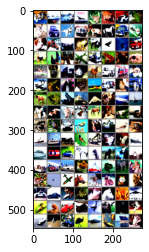

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
with torch.no_grad():
    images, labels = images.to(device), labels.to(device)
    outputs = model(images) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship  ship plane


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
print('Accuracy of the network on the 10000 test images: %.2f %%' % (
    get_test_accuracy(model, testloader, device)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the 10000 test images: 85.62 %


The accuracy 85.62 is far better than chance, which is 10% accuracy (randomly picking a class out of 10 classes).
Seems like the network learnt good.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
class_correct,class_total = get_accuracy_per_class(model, testloader, device)

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of plane : 86 %
Accuracy of   car : 96 %
Accuracy of  bird : 81 %
Accuracy of   cat : 73 %
Accuracy of  deer : 77 %
Accuracy of   dog : 78 %
Accuracy of  frog : 88 %
Accuracy of horse : 96 %
Accuracy of  ship : 93 %
Accuracy of truck : 84 %


## Plot the performance metrics

In this step, the following metrics are plotted

i. Training Loss
ii. Training Accuracy
iii. Test Loss
iv. Test Accuracy

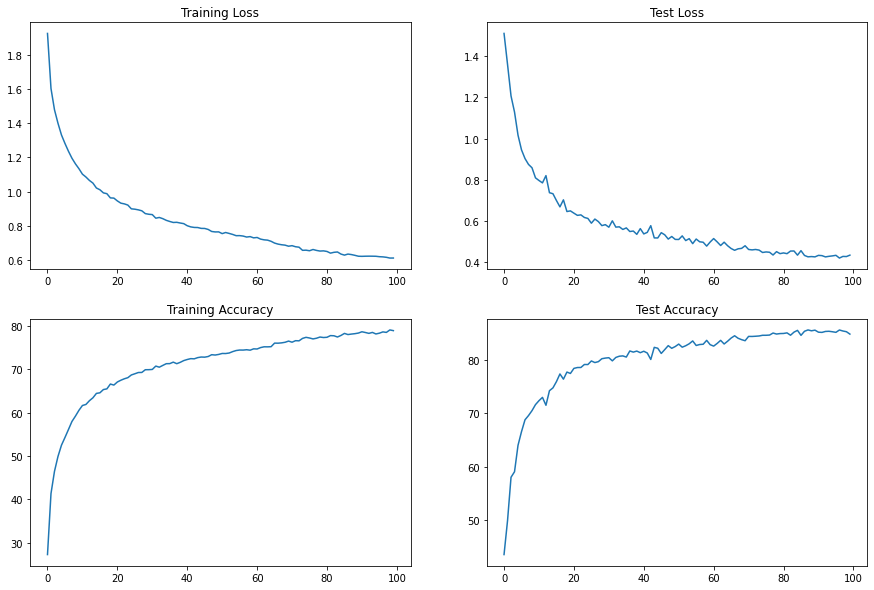

In [ ]:
plot_loss_accuracy(train_losses, train_acc, test_losses, test_acc)

## Display Misclassified Images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range f

([array([[[ 0.20728293,  0.32359242,  0.45928684, ...,  0.84698516,
            0.43990195, -0.8588875 ],
          [ 0.3042075 ,  0.18789801,  0.3817472 , ...,  0.92452484,
            0.45928684, -0.82011765],
          [ 0.34297734,  0.01343376,  0.18789801, ...,  0.9632947 ,
            0.5562114 , -0.7813478 ],
          ...,
          [ 0.42051703,  0.42051703,  0.45928684, ...,  0.36236227,
            0.3817472 ,  0.18789801],
          [ 0.18789801,  0.2654377 ,  0.32359242, ...,  0.2848226 ,
            0.2654377 ,  0.24605277],
          [-0.16103049, -0.08349082,  0.07158852, ...,  0.12974326,
            0.12974326,  0.1685131 ]],
  
         [[ 0.21710233,  0.35477024,  0.53177184, ...,  0.92510873,
            0.5514387 , -0.7072394 ],
          [ 0.3351034 ,  0.27610287,  0.45310447, ...,  1.023443  ,
            0.61043924, -0.64823884],
          [ 0.3744371 ,  0.1187681 ,  0.29576972, ...,  1.0824435 ,
            0.70877343, -0.60890514],
          ...,
          [ 

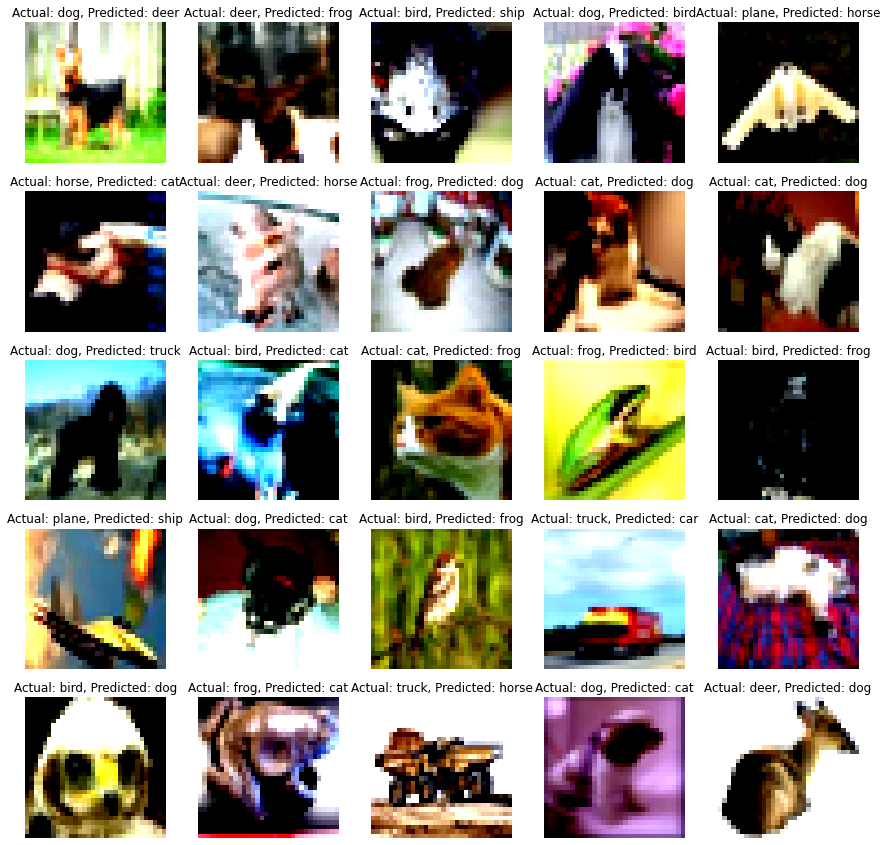

In [ ]:
display_misclassfied_ciphar10_images(testloader, model, device, classes, 25)